<a href="https://colab.research.google.com/github/path-0f-misantrope/most_uselles_musor2/blob/main/%D0%BE%D1%82%D1%87%D0%B5%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


from xgboost import XGBClassifier  # Для Gradient Boosting
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("/content/train.csv")
df.info()
df.shape


<ipython-input-2-412c2cb385a2>:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,1282,1447,1448,1449,1450,1451,1452,1453,1454,1649,1650,1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB


(14456, 2666)

In [3]:
df.drop_duplicates()
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=constant_columns)
df = df.T.drop_duplicates().T




Удаление Одинаковых строк и столбцов

<Axes: >

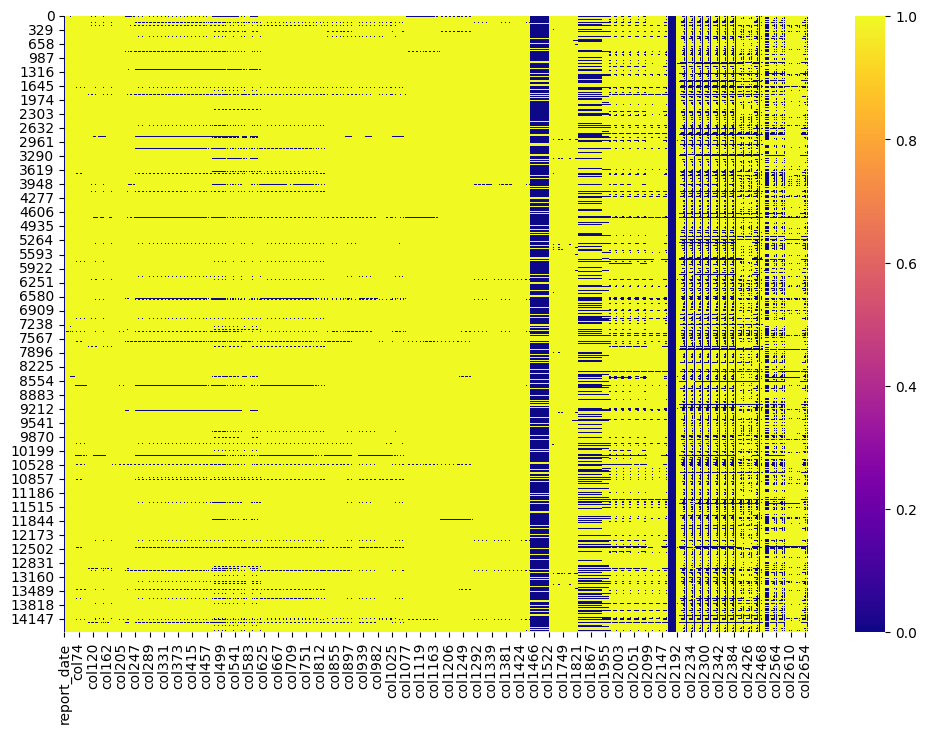

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cmap='plasma')


In [5]:
df.fillna(0, inplace=True)
for col in df.select_dtypes(include=['float', 'int']):
    mode = df[col].mode().iloc[0]  # Находим моду (первое значение в случае нескольких мод)
    df[col].fillna(mode, inplace=True)  # Заменяем NaN на моду

df = df.dropna(axis=1, how='all') # Удаление полностью пустых колонок

# Удаляем колонки, заполненные менее чем на 50%
threshold = 0.45 * len(df)
df = df.loc[:, df.notna().sum() >= threshold]

# Удаляем колонки, где все значения одинаковые
df = df.loc[:, df.nunique() > 1]

df.drop(['col1454'], axis = 1, inplace = True) # там хэши какие то мусор
df.drop(['report_date'], axis = 1, inplace = True) # удаляю дату потому что могу
# Импорт библиотек для работы с регулярными выражениями
import re

# Удаляем колонки, где есть хотя бы одна ссылка
df = df.drop(columns=[col for col in df.columns if df[col].astype(str).str.contains(r'http[s]?://', na=False).any()])





<ipython-input-5-ad81670e1eca>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
<ipython-input-5-ad81670e1eca>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode, inplace=True)  # Заменяем NaN на моду
<ipython-input-5-ad81670e1eca>:4: FutureWarning: A value is trying

  меняет все nan на 0.заполняет модой nan в числовых столбах(не сработало потому что они были обжектами). убирает колонки наполовину пустые. убирает все колонки со всеми одинаковыми значениями. удаляет ссылки.

<Axes: >

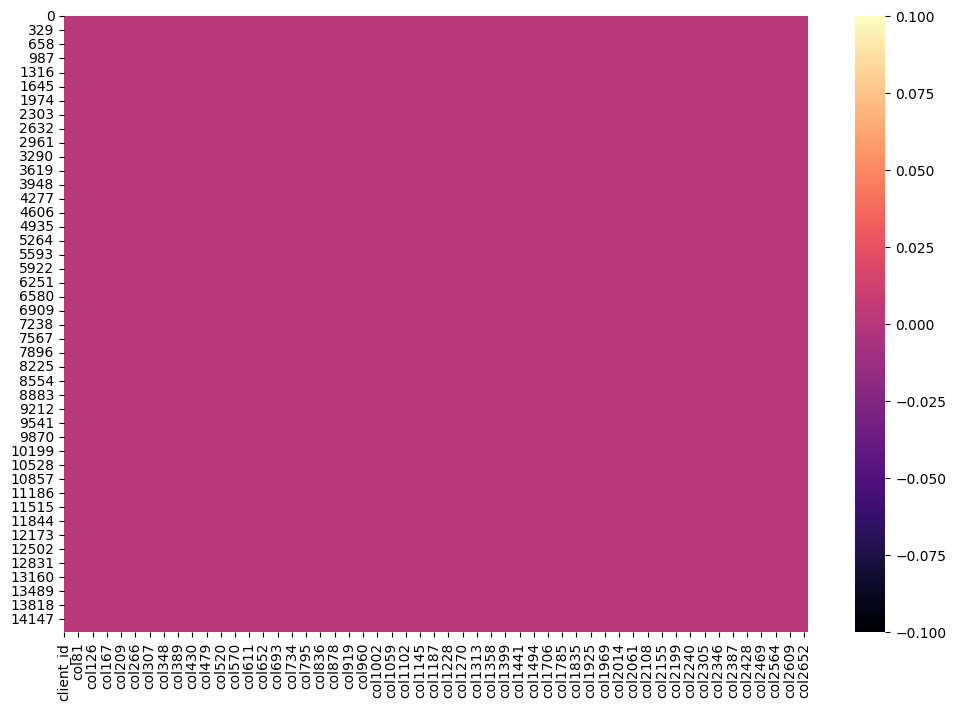

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cmap='magma')

In [7]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].replace(0, '').astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2144 entries, client_id to col2663
dtypes: float64(1859), int64(3), object(282)
memory usage: 236.5+ MB


замена 0 в object колонках на пустую строку


In [8]:
#from sklearn.ensemble import IsolationForest

#X = df.select_dtypes(include=['float', 'int']).dropna()
##iso.fit(X)

# Предсказания: -1 = выбросы, 1 = нормальные данные
#df['is_outlier'] = iso.predict(X)
#print(df[df['is_outlier'] == -1])


из за большого количества нулей он считает все выбросами так что блииин((((

In [9]:
df.head(15)

,client_id,target,col1,col2,col3,col4,col7,col8,col27,col28,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256261
1,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7616803.0,7616803.0,7616803.0,0.0,0.0,0.0,7616803.0,7616803.0,7616803.0,0.256261
2,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256261
3,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258682
4,8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254164
5,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10850000.0,10850000.0,10850000.0,0.0,0.0,0.0,10850000.0,10850000.0,10850000.0,0.318994
6,16,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258853
7,17,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256261
8,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266285
9,19,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256261


и тут я понял что только nan на моду менял
но пока оставлю ченет



# Настройка моделей


In [10]:
df_to_cod = df
categorical_columns = df_to_cod.select_dtypes(include=['object']).columns.tolist()
for col in df[categorical_columns]:

        le = LabelEncoder()  # Создаем новый LabelEncoder
        df_to_cod[col] = le.fit_transform(df[col])  # Кодируем колонку
X = df_to_cod.drop(columns=['target'])  # Замените 'target' на название вашей целевой переменной
y = df_to_cod['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


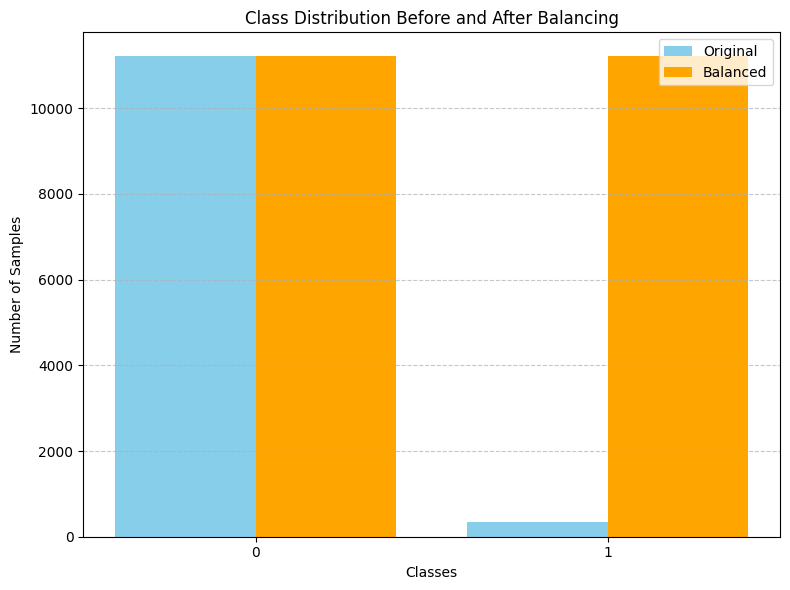

In [53]:


# Подсчитаем количество примеров каждого класса до и после балансировки
original_class_counts = np.bincount(y_train)
balanced_class_counts = np.bincount(y_train_balanced)

# Построим график
classes = range(len(original_class_counts))  # Классы (например, 0 и 1)
width = 0.4  # Ширина столбцов

plt.figure(figsize=(8, 6))

# Гистограмма для исходного распределения
plt.bar([c - width/2 for c in classes], original_class_counts, width=width, label="Original", color="skyblue")

# Гистограмма для сбалансированного распределения
plt.bar([c + width/2 for c in classes], balanced_class_counts, width=width, label="Balanced", color="orange")

# Настройка графика
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before and After Balancing")
plt.xticks(classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Отобразить график
plt.show()


\кодирование категориальных данных и балансировка с помощью smote

In [11]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Gradient Boosting (XGBoost)
gb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)

использовал 2 модели RandomForestClassifier и Xgboost

In [12]:
# Random Forest
 #rf_model.fit(X_train, y_train)

# Gradient Boosting
#gb_model.fit(X_train, y_train)

In [13]:
'''
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
grid_rf.fit(X_train, y_train)
print("Best Random Forest Parameters:", grid_rf.best_params_)

 для Gradient Boosting
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 10]}
grid_gb = GridSearchCV(XGBClassifier(random_state=42), gb_params, cv=3)
grid_gb.fit(X_train, y_train)
print("Best Gradient Boosting Parameters:", grid_gb.best_params_)
'''

'\nrf_params = {\'n_estimators\': [100, 200], \'max_depth\': [10, 20, None]}\ngrid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)\ngrid_rf.fit(X_train, y_train)\nprint("Best Random Forest Parameters:", grid_rf.best_params_)\n\n для Gradient Boosting\ngb_params = {\'n_estimators\': [100, 200], \'learning_rate\': [0.05, 0.1], \'max_depth\': [3, 5, 10]}\ngrid_gb = GridSearchCV(XGBClassifier(random_state=42), gb_params, cv=3)\ngrid_gb.fit(X_train, y_train)\nprint("Best Gradient Boosting Parameters:", grid_gb.best_params_)\n'

поиск лучших гиперпараметров с помощью gridsearch

In [39]:
rf_model = RandomForestClassifier(class_weight='balanced',n_estimators= 100,max_depth= None, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Обучение XGBClassifier
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = XGBClassifier(scale_pos_weight=pos_weight,n_estimators= 200,learning_rate=0.1,max_depth= 10,random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

йоуууу я на это час потратил


# Оценка качетсва и валидация

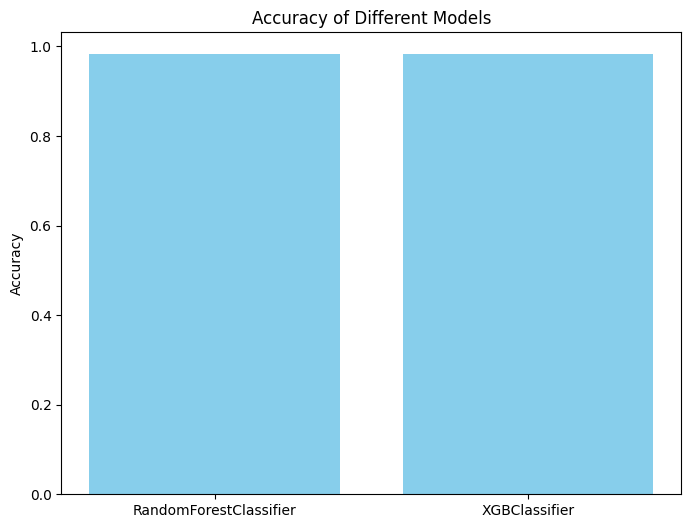

In [40]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix



# Словарь для хранения метрик
metrics = {}

# Модели
models = {
    'RandomForestClassifier':rf_model,
    'XGBClassifier': xgb_model
}

# Обучение моделей и вычисление метрик
for model_name, model in models.items():
    # Получаем предсказания
    y_pred = model.predict(X_test)

    # Вычисляем метрики
    metrics[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    # Для ROC и AUC
    if len(set(y_test)) == 2:  # Проверяем, что задача бинарная
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        metrics[model_name]['fpr'] = fpr
        metrics[model_name]['tpr'] = tpr
        metrics[model_name]['roc_auc'] = auc(fpr, tpr)

# 1. График точности
model_names = list(metrics.keys())
accuracy_values = [metrics[model]['accuracy'] for model in model_names]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_values, color='skyblue')
plt.title('Accuracy of Different Models')
plt.ylabel('Accuracy')
plt.show()



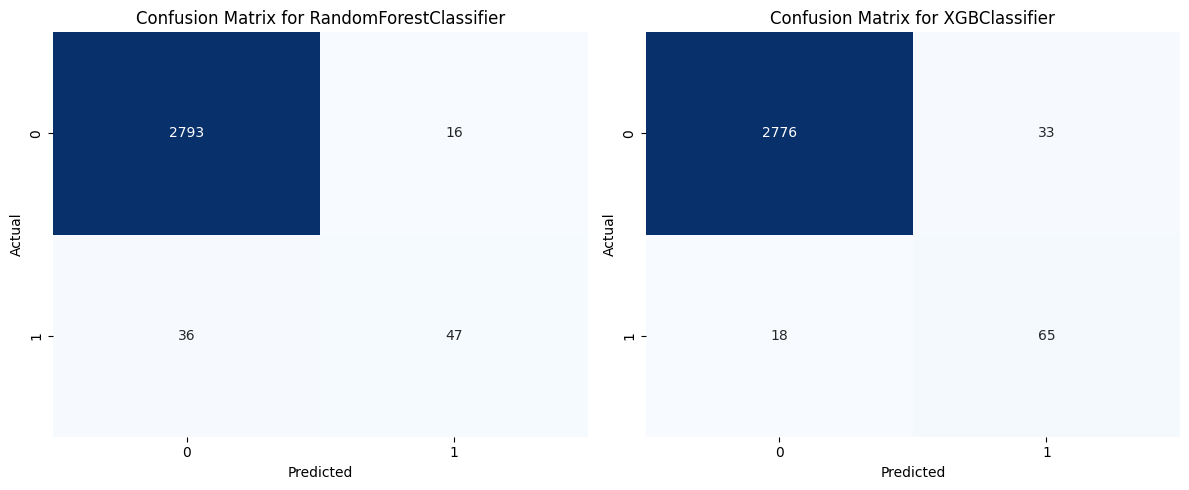

In [41]:
fig, axes = plt.subplots(1, len(models), figsize=(12, 5))

for idx, (model_name, model) in enumerate(models.items()):
    cm = metrics[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix for {model_name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()






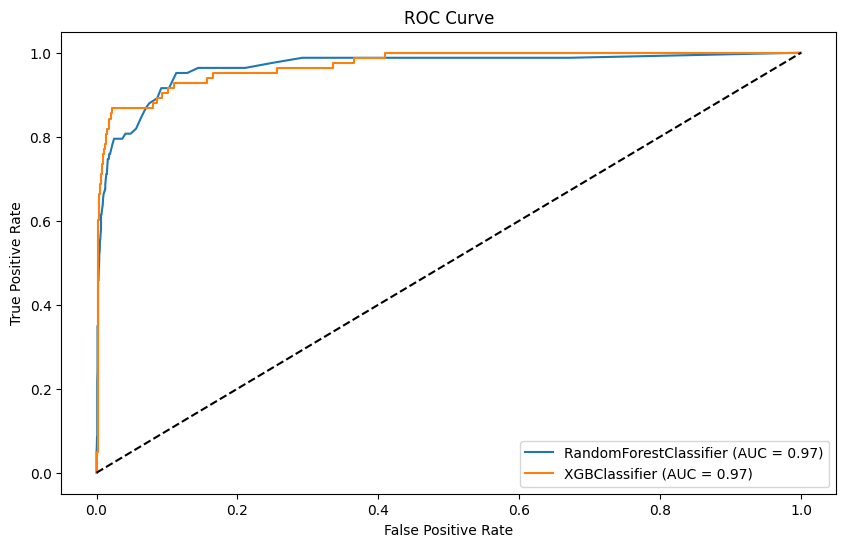

In [42]:
# 3. ROC-кривые (если задача бинарная)
if 'roc_auc' in metrics['RandomForestClassifier']:
    plt.figure(figsize=(10, 6))
    for model_name, model in models.items():
        fpr = metrics[model_name]['fpr']
        tpr = metrics[model_name]['tpr']
        auc_score = metrics[model_name]['roc_auc']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного классификатора
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

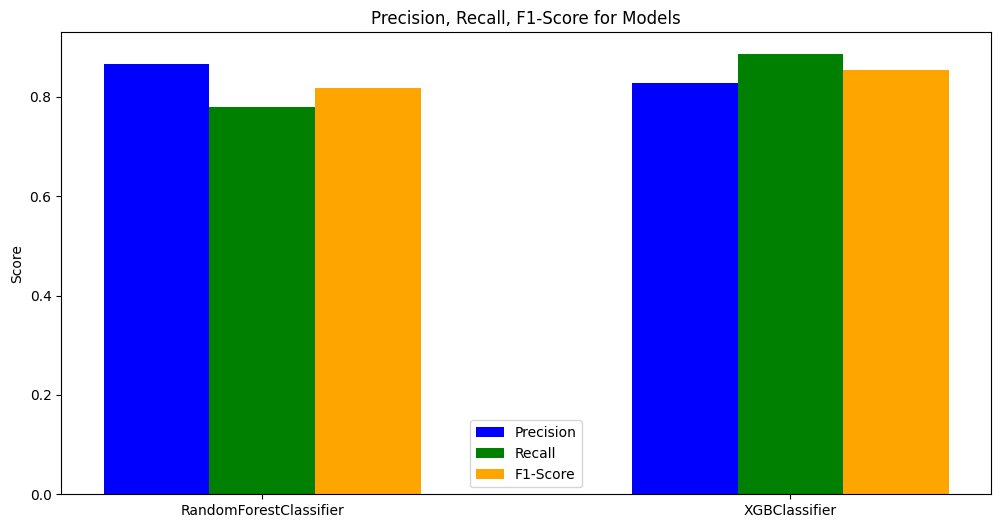

In [43]:
# 2. Графики Precision, Recall и F1-Score
precision_values = [metrics[model]['precision'] for model in models]
recall_values = [metrics[model]['recall'] for model in models]
f1_values = [metrics[model]['f1'] for model in models]
model_names = list(models.keys())

plt.figure(figsize=(12, 6))
x = range(len(models))

plt.bar([i - 0.2 for i in x], precision_values, width=0.2, label='Precision', align='center', color='blue')
plt.bar(x, recall_values, width=0.2, label='Recall', align='center', color='green')
plt.bar([i + 0.2 for i in x], f1_values, width=0.2, label='F1-Score', align='center', color='orange')

plt.xticks(x, model_names)
plt.title('Precision, Recall, F1-Score for Models')
plt.ylabel('Score')
plt.legend()
plt.show()

In [44]:
# Вывод метрик в консоль
for model_name, model_metrics in metrics.items():
    print(f"Metrics for {model_name}:")
    print(f"  Accuracy: {model_metrics['accuracy']:.4f}")
    print(f"  Precision: {model_metrics['precision']:.4f}")
    print(f"  Recall: {model_metrics['recall']:.4f}")
    print(f"  F1-Score: {model_metrics['f1']:.4f}")
    print()


Metrics for RandomForestClassifier:
  Accuracy: 0.9820
  Precision: 0.8667
  Recall: 0.7803
  F1-Score: 0.8173

Metrics for XGBClassifier:
  Accuracy: 0.9824
  Precision: 0.8284
  Recall: 0.8857
  F1-Score: 0.8546



**Metrics for RandomForestClassifier:**
  Accuracy: 0.9817

  Precision: 0.9051

  Recall: 0.7275

  F1-Score: 0.7899


***Metrics for XGBClassifier:***
  
  Accuracy: 0.9862
  
  Precision: 0.9328
  
  Recall: 0.8000
  
  F1-Score: 0.8536

# Валидация на другом датасете

In [20]:
valid = pd.read_csv('/content/valid.csv')


<ipython-input-20-63bb3edf773d>:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,91,95,96,97,99,131,132,133,135,136,140,141,142,144,145,146,147,148,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,207,208,211,212,213,215,216,239,240,241,243,244,245,459,467,563,567,571,575,579,580,583,611,612,795,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1047,1055,1063,1064,1071,1072,1073,1074,1175,1176,1177,1178,1179,1180,1181,1182,1277,1278,1281,1282,1447,1448,1449,1450,1451,1452,1453,1454,1653,1654,1656,2193,2194,2195,2196,2199) have mixed types. Specify dtype option on import or set low_memory=False.
  valid = pd.read_csv('/content/valid.csv')


In [21]:
valid.fillna(0, inplace=True)


valid = df.dropna(axis=1, how='all') # Удаление полностью пустых колонок

# Удаляем колонки, заполненные менее чем на 50%
threshold = 0.45 * len(valid)
valid = df.loc[:, df.notna().sum() >= threshold]

# Удаляем колонки, где все значения одинаковые
valid = df.loc[:, df.nunique() > 1]


# Импорт библиотек для работы с регулярными выражениями
import re

# Удаляем колонки, где есть хотя бы одна ссылка
valid = valid.drop(columns=[col for col in df.columns if df[col].astype(str).str.contains(r'http[s]?://', na=False).any()])
for col in valid.select_dtypes(include=['object']).columns:
    valid[col] = valid[col].replace(0, '').astype(str)

In [22]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2144 entries, client_id to col2663
dtypes: float64(1859), int64(285)
memory usage: 236.5 MB


кодировка валид. датасета

In [23]:
# Оставляем только те колонки в валидационном датасете, которые есть в обучающемc
valid = df[df.columns.intersection(df.columns)]
missing_columns = set(df.columns) - set(valid.columns)

for col in missing_columns:
    valid[col] = 0  # Или другое значение, например, среднее/медиану по обучающему набору

# Приводим порядок колонок к обучающему набору
valid = valid[df.columns]

In [24]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2144 entries, client_id to col2663
dtypes: float64(1859), int64(285)
memory usage: 236.5 MB


In [26]:
categorical_columns = valid.select_dtypes(include=['object']).columns.tolist()


Приведение валидационного датасета к совместимому для модели

In [27]:
valid1 = valid
for col in df[categorical_columns]:

        le = LabelEncoder()  # Создаем новый LabelEncoder
        valid1[col] = le.fit_transform(valid[col])  # Кодируем колонку


In [28]:
X_val = valid1.drop(columns=['target'])
y_val = valid1['target']

# тестирование и оценка на валидационном датасете

In [45]:
val_metrics = {}
rf_predictions = rf_model.predict(X_val)
xgb_predictions = gb_model.predict(X_val)

# Добавление предсказаний в валидационный датасет
val_data = X_val.copy()  # Создаем копию валидационного набора (X_val)
val_data['y_true'] = y_val  # Добавляем истинные значения целевой переменной
val_data['rf_predicted'] = rf_predictions  # Добавляем предсказания RandomForestClassifier
val_data['xgb_predicted'] = xgb_predictions  # Добавляем предсказания XGBClassifier

# Расчет метрик для каждой модели
for model_name, model in models.items():
    # Предсказания на валидационном наборе
    y_val_pred = model.predict(X_val)

    val_metrics[model_name] = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred, average='macro', zero_division=0),
        'recall': recall_score(y_val, y_val_pred, average='macro'),
        'f1': f1_score(y_val, y_val_pred, average='macro'),
        'confusion_matrix': confusion_matrix(y_val, y_val_pred)
    }

# Вывод метрик на валидационном наборе
for model_name, model_metrics in val_metrics.items():
    print(f"Validation Metrics for {model_name}:")
    print(f"  Accuracy: {model_metrics['accuracy']:.4f}")
    print(f"  Precision: {model_metrics['precision']:.4f}")
    print(f"  Recall: {model_metrics['recall']:.4f}")
    print(f"  F1-Score: {model_metrics['f1']:.4f}")
    print()

Validation Metrics for RandomForestClassifier:
  Accuracy: 0.9964
  Precision: 0.9795
  Recall: 0.9581
  F1-Score: 0.9686

Validation Metrics for XGBClassifier:
  Accuracy: 0.9963
  Precision: 0.9597
  Recall: 0.9781
  F1-Score: 0.9687



отлично получилось мне нравится♥♥

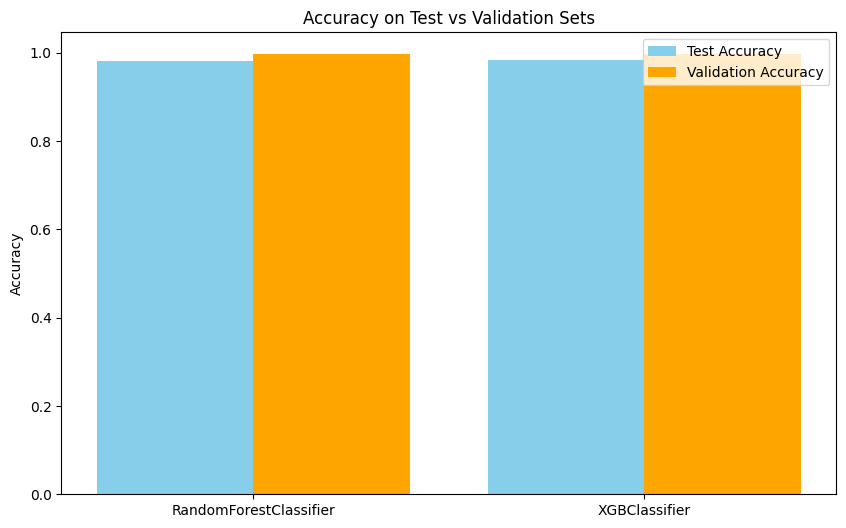

In [46]:
# Сравнение точности на тестовом и валидационном наборах
test_accuracies = [metrics[model]['accuracy'] for model in model_names]
val_accuracies = [val_metrics[model]['accuracy'] for model in model_names]

plt.figure(figsize=(10, 6))
x = range(len(model_names))

plt.bar([i - 0.2 for i in x], test_accuracies, width=0.4, label='Test Accuracy', color='skyblue')
plt.bar([i + 0.2 for i in x], val_accuracies, width=0.4, label='Validation Accuracy', color='orange')

plt.xticks(x, model_names)
plt.ylabel('Accuracy')
plt.title('Accuracy on Test vs Validation Sets')
plt.legend()
plt.show()


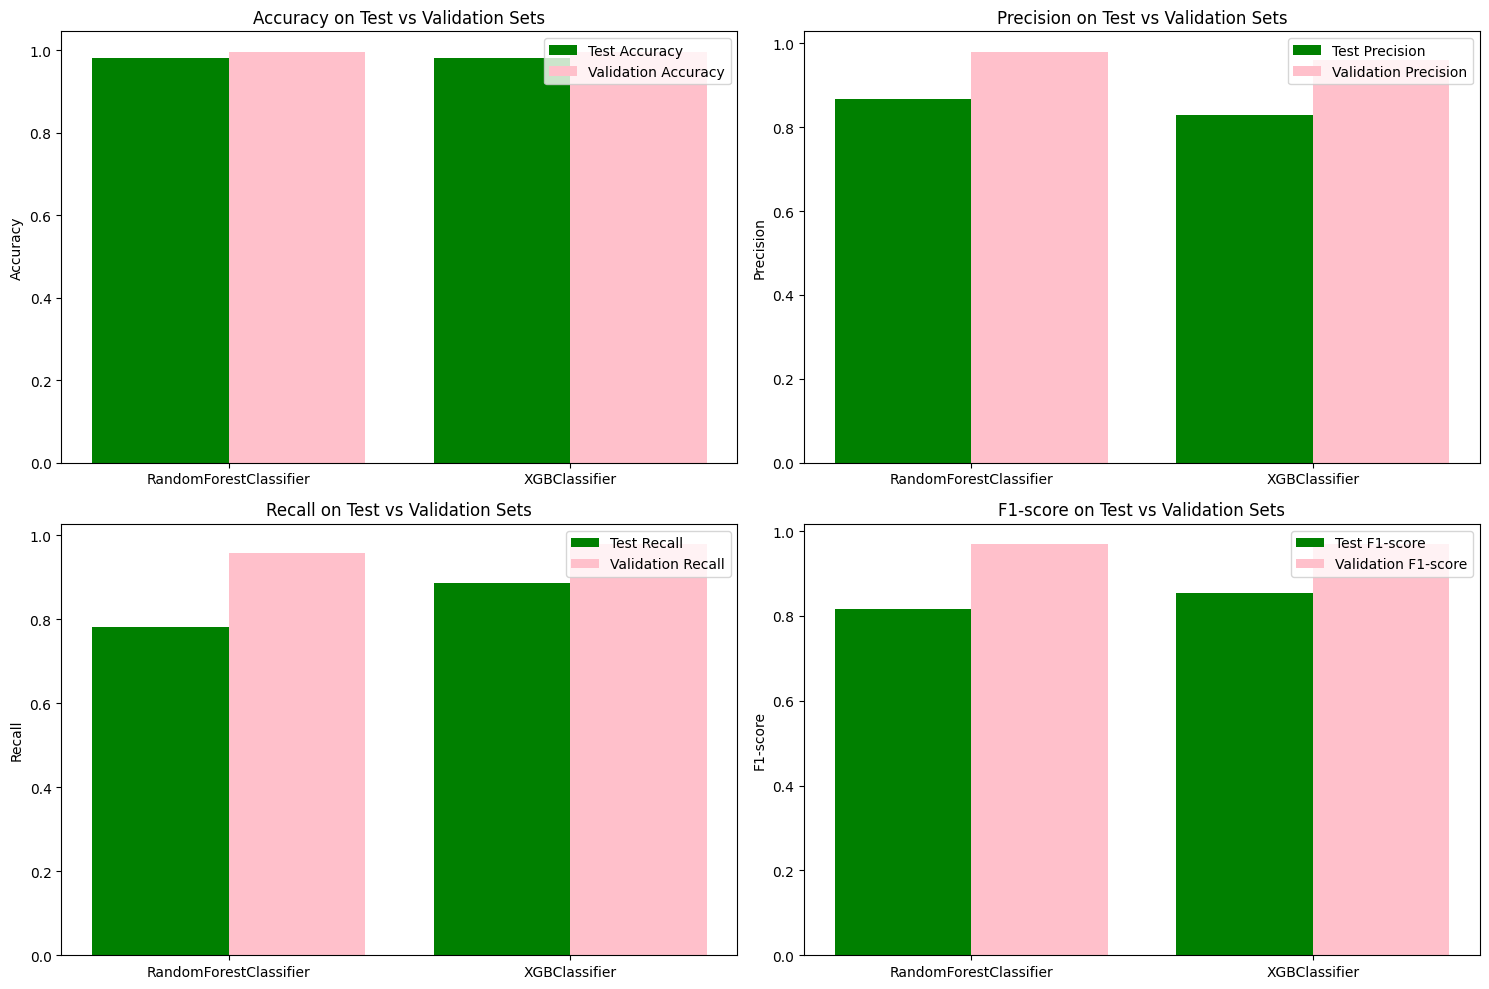

In [47]:
metric_names = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Построение графиков для каждой метрики
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metric_names):
    # Значения метрики для тестового и валидационного наборов
    test_values = [metrics[model][metric] for model in model_names]
    val_values = [val_metrics[model][metric] for model in model_names]

    # Создаем подграфик
    plt.subplot(2, 2, i + 1)  # 2x2 сетка графиков

    x = range(len(model_names))

    # Гистограммы для тестового и валидационного наборов
    plt.bar([i - 0.2 for i in x], test_values, width=0.4, label='Test ' + metric_labels[i], color='green')
    plt.bar([i + 0.2 for i in x], val_values, width=0.4, label='Validation ' + metric_labels[i], color='pink')

    # Настройки графика
    plt.xticks(x, model_names)
    plt.ylabel(metric_labels[i])
    plt.title(f'{metric_labels[i]} on Test vs Validation Sets')
    plt.legend()

# Показываем все графики
plt.tight_layout()
plt.show()

In [52]:
# Фильтруем строки, где хотя бы одна из моделей ошиблась
errors = val_data[(val_data['rf_predicted'] != val_data['y_true']) |
                  (val_data['xgb_predicted'] != val_data['y_true'])]

# Построчный вывод только ошибок
for index, row in errors.iterrows():

    print(f"  True Value (y_true): {row['y_true']}")
    print(f"  RF Predicted: {row['rf_predicted']}")
    print(f"  XGB Predicted: {row['xgb_predicted']}")
    print("-" * 40)  # Разделитель между строками


  True Value (y_true): 1.0
  RF Predicted: 0.0
  XGB Predicted: 0.0
----------------------------------------
  True Value (y_true): 0.0
  RF Predicted: 1.0
  XGB Predicted: 0.0
----------------------------------------
  True Value (y_true): 0.0
  RF Predicted: 0.0
  XGB Predicted: 1.0
----------------------------------------
  True Value (y_true): 1.0
  RF Predicted: 0.0
  XGB Predicted: 0.0
----------------------------------------
  True Value (y_true): 1.0
  RF Predicted: 0.0
  XGB Predicted: 0.0
----------------------------------------
  True Value (y_true): 0.0
  RF Predicted: 1.0
  XGB Predicted: 0.0
----------------------------------------
  True Value (y_true): 0.0
  RF Predicted: 1.0
  XGB Predicted: 0.0
----------------------------------------
  True Value (y_true): 0.0
  RF Predicted: 1.0
  XGB Predicted: 1.0
----------------------------------------
  True Value (y_true): 0.0
  RF Predicted: 1.0
  XGB Predicted: 1.0
----------------------------------------
  True Value (y_tru

Вывод: РандомФорест работает лучше на пару процентов